In [1]:
import pandas as pd
import numpy as np

Kode ini berisi 2 jenis data generation
1. Bagian atas, CI dari emisi total
2. Bagian bawah, CI dari grand total emisi 

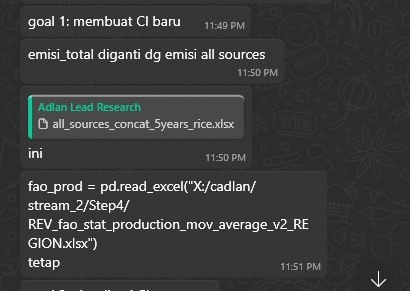

In [2]:
# luc_crops = pd.read_excel("X:/cadlan/stream_2/Step4/Country Level/AM1/luc_crop_per_crops_AM1_region.xlsx")
# agri_to_agri = pd.read_excel("X:/cadlan/stream_2/Step4/Country Level/AM1/agri_to_agri_prop_crop_AM1_region.xlsx")

emisi_total = pd.read_excel("D:/kerja/asisten riset/code rev/all_sources_concat_5years_rice.xlsx")

fao_prod = pd.read_excel("D:/kerja/asisten riset/code v/review/REV_fao_stat_production_mov_average_v2_REGION.xlsx", engine='openpyxl')

#Carbon Intensity = emisi/ production
# production
#df3. FAO (FAO_stat_production)

#CI1 = emisi/ df3


In [10]:
emisi_total_copy = emisi_total.copy()
emisi_total_copy = emisi_total_copy.drop(columns=['Unnamed: 0'])
emisi_total_copy = emisi_total_copy.rename(columns={'type':'NGFBFC'})
emisi_total_copy['NGFBFC'] = emisi_total_copy['NGFBFC'].str.lower()
emisi_total_copy = emisi_total_copy[emisi_total_copy['NGFBFC'] != "pasture"]
emisi_total_groupby = emisi_total_copy.groupby(['IMAGE Region Name', 'NGFBFC']).sum().reset_index()
emisi_total_groupby = emisi_total_groupby.drop(columns=['emissions', 'category'])

emisi_total_melted = pd.melt(emisi_total_groupby, id_vars=['IMAGE Region Name', 'NGFBFC'], var_name='time', value_name='value')
emisi_total_melted_groupby = emisi_total_melted.groupby(['IMAGE Region Name', 'time', 'NGFBFC']).sum().reset_index()
#convert dari Gt CO2 ke t CO2
emisi_total_melted_groupby['value'] = emisi_total_melted_groupby['value'] * 1E9
emisi_total_melted_groupby

,IMAGE Region Name,time,NGFBFC,value
0,Brazil,1975,maize,4.311822e+08
1,Brazil,1975,"non food, luxury, spices",1.124009e+08
2,Brazil,1975,palm oil,2.561441e+05
3,Brazil,1975,plant based fibres,2.125639e+08
4,Brazil,1975,pulses,1.777147e+08
...,...,...,...,...
4155,W. Europe,2020,tropical cereals,6.875468e+05
4156,W. Europe,2020,tropical oil crops,9.294834e+03
4157,W. Europe,2020,tropical roots & tubers,4.021869e+03
4158,W. Europe,2020,vegetables & fruits,1.542223e+07


In [11]:
fao_prod_copy = fao_prod.copy()
fao_prod_copy['NGFBFC'] = fao_prod_copy['NGFBFC'].str.lower()
fao_prod_copy['NGFBFC'] = fao_prod_copy['NGFBFC'].str.replace('oil & palm fruit', 'palm oil').replace('other non-food & luxury & spices', 'non food, luxury, spices').replace('other temperate cereals', 'temperate cereals')
fao_prod_copy = fao_prod_copy[fao_prod_copy['time'] >= 1975]
fao_prod_copy

,IMAGE Region Name,time,NGFBFC,FAO Production
16,Brazil,1975,maize,1.676013e+07
17,Brazil,1975,palm oil,4.040000e+04
18,Brazil,1975,"non food, luxury, spices",1.753227e+06
19,Brazil,1975,temperate cereals,1.268408e+05
20,Brazil,1975,plant based fibres,2.253283e+06
...,...,...,...,...
4274,W. Europe,2020,tropical cereals,7.002724e+05
4275,W. Europe,2020,tropical oil crops,0.000000e+00
4276,W. Europe,2020,tropical roots & tubers,0.000000e+00
4277,W. Europe,2020,vegetables & fruits,9.706803e+07


FAO akumulasi

In [12]:
# 1 b c
df_copy_fao = fao_prod_copy.copy()

for region, time, ngfbfc in zip(df_copy_fao["IMAGE Region Name"].to_list(), df_copy_fao["time"].to_list(), df_copy_fao["NGFBFC"].to_list()):
    try:
        data1 = fao_prod_copy[(fao_prod_copy['IMAGE Region Name'] == region) & (fao_prod_copy['time'] == time) & (fao_prod_copy['NGFBFC'] == ngfbfc)]['FAO Production'].to_numpy()
        data2 = emisi_total_melted_groupby[(emisi_total_melted_groupby['IMAGE Region Name'] == region) & (emisi_total_melted_groupby['time'] == time) & (emisi_total_melted_groupby['NGFBFC'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = df_copy_fao[(df_copy_fao['IMAGE Region Name'] == region) & (df_copy_fao['time'] == time) & (df_copy_fao['NGFBFC'] == ngfbfc)].index
        df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
    
    except (KeyError, ZeroDivisionError) as e:
        print(f"Error: {e} for region {region}")

df_copy_fao = df_copy_fao.drop(columns=['FAO Production'])
df_copy_fao.head()

C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_1456/3931240757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_1456/3931240757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_1456/3931240757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_1456/3931240757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\HEFRYA~1\AppData\Local\Temp/ipykernel_1456/3931240757.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\H

,IMAGE Region Name,time,NGFBFC,Carbon Intensity
16,Brazil,1975,maize,25.726668
17,Brazil,1975,palm oil,6.340201
18,Brazil,1975,"non food, luxury, spices",64.110875
19,Brazil,1975,temperate cereals,99.837592
20,Brazil,1975,plant based fibres,94.335192


In [18]:
df_copy_fao['Carbon Intensity'] = df_copy_fao['Carbon Intensity'].replace([np.inf, -np.inf], np.nan)
df_copy_fao['Carbon Intensity'] = df_copy_fao['Carbon Intensity'].fillna(0)

In [19]:
df_copy_fao.to_csv("/CI_emisi_total_FAO_AM1_now.csv", index=False)

BAGIAN 2

In [2]:
grand_total = pd.read_excel("Z:/achaidir/IMAGE PBL/maps/validasi/grand_total_per_crops_ccode_region.xlsx")
grand_total

,IMAGE Region Name,type,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
0,Brazil,grass,4.965240,3.583152,2.602972,2.522530,1.683974,1.790621,3.104259,1.323259,2.043773,1.641534
1,Brazil,maize,0.471922,0.267001,0.235553,0.513603,1.292657,0.460758,0.410340,0.271998,0.581869,0.507687
2,Brazil,oil & palm fruit,0.000276,0.000236,0.000411,0.003101,0.008169,0.004393,0.004110,0.003080,0.005919,0.005323
3,Brazil,other non-food & luxury & spices,0.125316,0.082242,0.084916,0.142155,0.307044,0.140367,0.072575,0.091439,0.120728,0.130757
4,Brazil,other temperate cereals,0.013689,0.010906,0.009288,0.020145,0.047192,0.021431,0.020213,0.006633,0.018420,0.012808
...,...,...,...,...,...,...,...,...,...,...,...,...
437,W. Europe,tropical cereals,0.000832,0.003345,0.000668,0.001286,0.000769,0.001092,0.000989,0.002479,0.002094,0.002189
438,W. Europe,tropical oil crops,0.000114,0.000108,0.000058,0.000021,0.000008,0.000006,0.000008,0.000015,0.000030,0.000024
439,W. Europe,tropical roots & tubers,0.000076,0.000084,0.000049,0.000037,0.000026,0.000015,0.000008,0.000004,0.000029,0.000020
440,W. Europe,vegetables & fruits,0.057337,0.066447,0.065089,0.061473,0.055783,0.056694,0.053136,0.048378,0.049488,0.042268


In [3]:
fao_prod = pd.read_excel("Z:/achaidir/IMAGE PBL/maps/validasi/REV_fao_stat_production_mov_average_v2_REGION.xlsx")
fao_prod

,IMAGE Region Name,time,NGFBFC,FAO Production
0,Brazil,1970,Maize,1.374886e+07
1,Brazil,1970,Oil & palm fruit,3.700000e+04
2,Brazil,1970,Other non-food & luxury & spices,1.887903e+06
3,Brazil,1970,Other temperate cereals,8.169200e+04
4,Brazil,1970,Plant based fibres,2.395394e+06
...,...,...,...,...
4274,W. Europe,2020,Tropical cereals,7.002724e+05
4275,W. Europe,2020,Tropical oil crops,0.000000e+00
4276,W. Europe,2020,Tropical roots & tubers,0.000000e+00
4277,W. Europe,2020,Vegetables & fruits,9.706803e+07


In [4]:
fao_prod['NGFBFC'] = fao_prod['NGFBFC'].str.lower()
fao_prod = fao_prod[fao_prod['time'] >= 1975]

In [6]:
grand_total_melted = pd.melt(grand_total, id_vars=['IMAGE Region Name', 'type'], var_name='time', value_name='value')
grand_total_melted_groupby = grand_total_melted.groupby(['IMAGE Region Name', 'time', 'type']).sum()
grand_total_melted_index = grand_total_melted_groupby.reset_index()
#convert dari Gt CO2 ke t CO2
grand_total_melted_index['value'] = grand_total_melted_index['value'] * 1E9
grand_total_melted_index

,IMAGE Region Name,time,type,value
0,Brazil,1975,grass,4.965240e+09
1,Brazil,1975,maize,4.719220e+08
2,Brazil,1975,oil & palm fruit,2.756744e+05
3,Brazil,1975,other non-food & luxury & spices,1.253158e+08
4,Brazil,1975,other temperate cereals,1.368920e+07
...,...,...,...,...
4415,W. Europe,2020,tropical cereals,2.189094e+06
4416,W. Europe,2020,tropical oil crops,2.371984e+04
4417,W. Europe,2020,tropical roots & tubers,2.017617e+04
4418,W. Europe,2020,vegetables & fruits,4.226805e+07


In [7]:
# 1 b c
df_copy_fao = fao_prod.copy()
for region, time, ngfbfc in zip(df_copy_fao["IMAGE Region Name"].to_list(), df_copy_fao["time"].to_list(), df_copy_fao["NGFBFC"].to_list()):
    try:
        data1 = fao_prod[(fao_prod['IMAGE Region Name'] == region) & (fao_prod['time'] == time) & (fao_prod['NGFBFC'] == ngfbfc)]['FAO Production'].to_numpy()
        data2 = grand_total_melted_index[(grand_total_melted_index['IMAGE Region Name'] == region) & (grand_total_melted_index['time'] == time) & (grand_total_melted_index['type'] == ngfbfc)]['value'].to_numpy()
        if data1.size == 0:
            data1 = [0]
        if data2.size == 0: 
            data2 = [0]
        mask = df_copy_fao[(df_copy_fao['IMAGE Region Name'] == region) & (df_copy_fao['time'] == time) & (df_copy_fao['NGFBFC'] == ngfbfc)].index
        df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
    except KeyError or  ZeroDivisionError:
        print(f"Error: {KeyError} for region {region}")

df_copy_fao = df_copy_fao.drop(columns=['FAO Production'])
df_copy_fao.head()

C:\Users\Achaidir\AppData\Local\Temp\ipykernel_34884\699054795.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]
C:\Users\Achaidir\AppData\Local\Temp\ipykernel_34884\699054795.py:12: RuntimeWarning: invalid value encountered in scalar divide
  df_copy_fao.loc[mask, 'Carbon Intensity'] =  data2[0] / data1[0]


,IMAGE Region Name,time,NGFBFC,Carbon Intensity
16,Brazil,1975,maize,28.157429
17,Brazil,1975,oil & palm fruit,6.823623
18,Brazil,1975,other non-food & luxury & spices,71.477226
19,Brazil,1975,other temperate cereals,107.924276
20,Brazil,1975,plant based fibres,101.943631


In [8]:
df_copy_fao.to_excel("Z:/achaidir/IMAGE PBL/maps/validasi/CI_grand_total_FAO.xlsx")